<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/PCA-XGBoost-3/Instacart_2017_PCA_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Garbage Collector to free up memory
import gc                         
gc.enable()

cluster_count = 3
c1, c2 = 2, 3

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders_50.csv")
order_products_prior = pd.read_csv("op_prior_50.csv")
order_products_train = pd.read_csv("op_train_50.csv")
# orders = pd.read_csv("orders_100.csv")
# order_products_prior = pd.read_csv("op_prior_100.csv")
# order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (831792, 7)
products:  (49688, 4)
order_products_prior:  (7882503, 4)
order_products_train:  (334239, 4)


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831792 entries, 0 to 831791
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                831792 non-null  int64  
 1   user_id                 831792 non-null  int64  
 2   eval_set                831792 non-null  object 
 3   order_number            831792 non-null  int64  
 4   order_dow               831792 non-null  int64  
 5   order_hour_of_day       831792 non-null  int64  
 6   days_since_prior_order  781793 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 44.4+ MB


In [4]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882503 entries, 0 to 7882502
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 240.6 MB


In [5]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


orders['order_dow'] = orders['order_dow'].astype('int8')
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int8')
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')
orders['user_id'] = orders['user_id'].astype('int32')
orders['order_id'] = orders['order_id'].astype('int32')
order_products_prior['order_id'] = order_products_prior['order_id'].astype('int32')
order_products_prior['product_id'] = order_products_prior['product_id'].astype('int16')
order_products_prior['add_to_cart_order'] = order_products_prior['add_to_cart_order'].astype('int8')
order_products_prior['reordered'] = order_products_prior['reordered'].astype('int8')

In [6]:
print('orders.shape =', orders.shape)
orders.head()

orders.shape = (831792, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_prior = pd.merge(order_products_prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
991482,431534,196,1,1,1,prior,5,4,15,28.0
991483,431534,12427,2,1,1,prior,5,4,15,28.0
991484,431534,10258,3,1,1,prior,5,4,15,28.0
991485,431534,25133,4,1,1,prior,5,4,15,28.0
991486,431534,10326,5,0,1,prior,5,4,15,28.0


In [8]:
_mt = pd.merge(order_products_prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
_mt = pd.merge(_mt,departments,on=['department_id','department_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,22352,prior,4,1,12,30.0,household,laundry
1,125669,15873,5,0,Dryer Sheets Geranium Scent,75,17,11895,prior,2,3,14,7.0,household,laundry
2,258957,15873,8,0,Dryer Sheets Geranium Scent,75,17,4082,prior,1,6,8,NaN,household,laundry
3,800020,15873,8,0,Dryer Sheets Geranium Scent,75,17,28162,prior,8,1,16,13.0,household,laundry
4,954344,15873,5,0,Dryer Sheets Geranium Scent,75,17,38545,prior,2,6,15,6.0,household,laundry
5,1402169,15873,1,1,Dryer Sheets Geranium Scent,75,17,26431,prior,31,5,12,4.0,household,laundry
6,1426347,15873,3,0,Dryer Sheets Geranium Scent,75,17,10830,prior,20,3,11,29.0,household,laundry
7,1426347,11162,10,0,Bac-Out Stain + Odor Remover Live Enzyme Cultu...,75,17,10830,prior,20,3,11,29.0,household,laundry
8,1451247,15873,4,0,Dryer Sheets Geranium Scent,75,17,34910,prior,33,0,15,5.0,household,laundry
9,1451247,11675,3,0,Lemon Verbena 4x Concentrated Laundry Detergent,75,17,34910,prior,33,0,15,5.0,household,laundry


In [9]:
mt['product_name'].value_counts()[0:10]

Banana                    115371
Bag of Organic Bananas     92533
Organic Strawberries       63994
Organic Baby Spinach       59783
Strawberries               34878
Limes                      34034
Organic Raspberries        34000
Organic Whole Milk         33409
Organic Yellow Onion       28290
Organic Garlic             27278
Name: product_name, dtype: int64

In [10]:
mt['department'].value_counts()[0:10]

produce            1484889
dairy eggs          861482
snacks              451826
beverages           423339
frozen              367285
pantry              302432
bakery              199421
canned goods        186325
deli                178173
dry goods pasta     137431
Name: department, dtype: int64

In [11]:
len(mt['product_name'].unique())

30953

In [12]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     590342
fresh vegetables                 523866
packaged vegetables fruits       266328
yogurt                           218212
milk                             168877
packaged cheese                  163626
water seltzer sparkling water    125853
chips pretzels                   114190
bread                            105184
soy lactosefree                   94996
Name: aisle, dtype: int64

PCA

In [13]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
# cust_prod = pd.crosstab(mt['department_id'], mt['user_id'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,0,2,0,31
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,14


In [14]:
cust_prod.shape

(49948, 134)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [16]:
ps = pd.DataFrame(pca_samples)
print('ps.shape =', ps.shape)
ps.head(8)

ps.shape = (49948, 4)


,0,1,2,3
0,-14.738253,2.703738,-1.557957,-1.292610
1,0.544502,20.516299,17.815604,8.551471
2,-7.918620,2.846710,-5.035365,-1.088444
3,-18.452461,-0.122752,-0.852733,0.863719
4,-11.219392,-1.859126,0.478458,2.511141
5,-17.541733,-2.392497,-0.153060,1.442064
6,7.099970,-0.182826,-5.157277,-3.420862
7,-6.955972,-12.789088,2.248275,2.236544


(49948, 2)
           2         3
0  -1.557957 -1.292610
1  17.815604  8.551471
2  -5.035365 -1.088444
3  -0.852733  0.863719
4   0.478458  2.511141


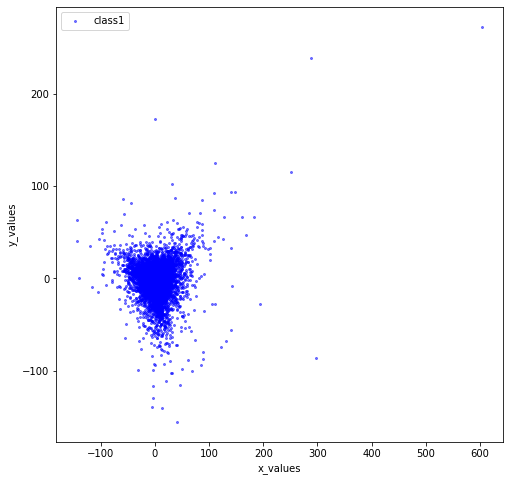

In [17]:

tocluster = pd.DataFrame(ps[[c1,c2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[c1], tocluster[c2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [18]:
# plot_pca(4, 1)

In [19]:
# plot_pca(0, 1)

In [20]:
# plot_pca(1,2)

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=cluster_count,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 33.9528766   12.47480631]
 [ -1.31747261   1.12230973]
 [  5.24113907 -18.43834683]]


In [22]:
print (c_preds[0:100])
print('c_preds.shape =', c_preds.shape)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
c_preds.shape = (49948,)


['blue', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


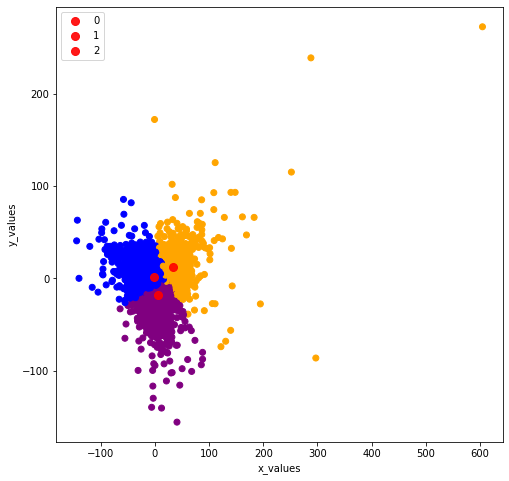

In [23]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[c1],tocluster[c2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [24]:
clust_prod = cust_prod.copy()
clust_prod['cluster_id'] = c_preds

clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster_id
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


(49948, 135)


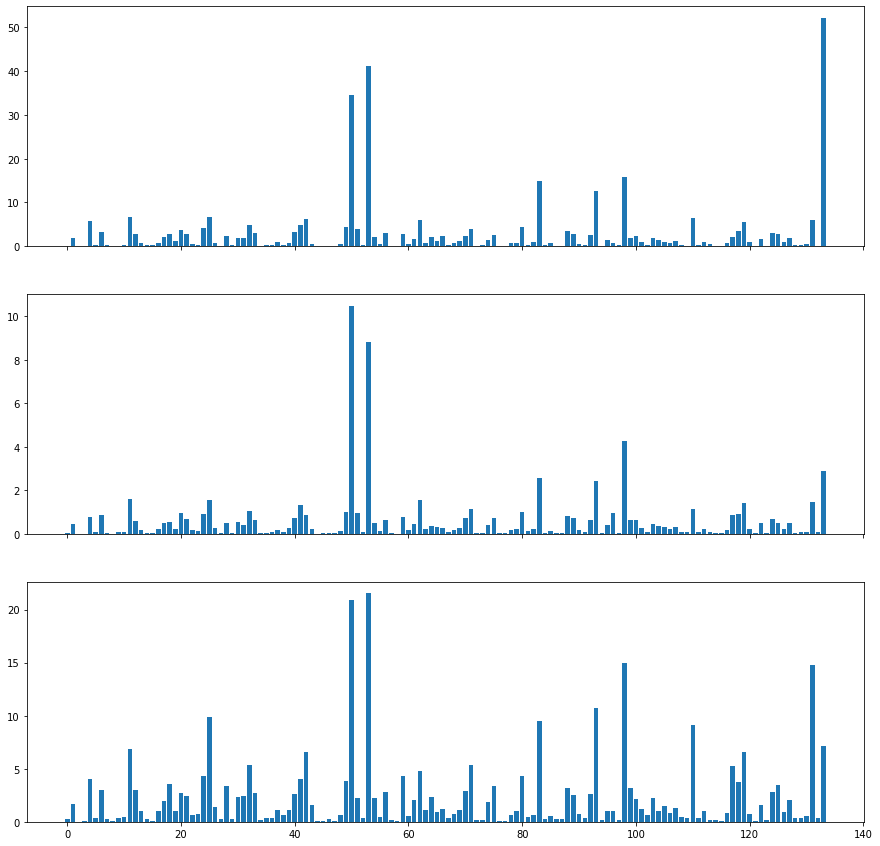

In [25]:
print (clust_prod.shape)
f,arr = plt.subplots(3,1,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster_id']==0])

c0 = clust_prod[clust_prod['cluster_id']==0].drop('cluster_id',axis=1).mean()
arr[0].bar(range(len(clust_prod.drop('cluster_id',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster_id']==1].drop('cluster_id',axis=1).mean()
arr[1].bar(range(len(clust_prod.drop('cluster_id',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster_id']==2].drop('cluster_id',axis=1).mean()
arr[2].bar(range(len(clust_prod.drop('cluster_id',axis=1).columns)),c2)

# c3 = clust_prod[clust_prod['cluster_id']==3].drop('cluster_id',axis=1).mean()
# arr[1,1].bar(range(len(clust_prod.drop('cluster_id',axis=1).columns)),c3)

plt.show()

In [26]:
c0.sort_values(ascending=False)[0:10]

aisle
yogurt                        52.204659
fresh vegetables              41.144759
fresh fruits                  34.633111
packaged vegetables fruits    15.811148
milk                          14.822795
packaged cheese               12.524126
bread                          6.703827
chips pretzels                 6.641431
refrigerated                   6.425957
energy granola bars            6.248752
dtype: float64

In [27]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     10.491688
fresh vegetables                  8.799712
packaged vegetables fruits        4.290249
yogurt                            2.876812
milk                              2.589994
packaged cheese                   2.442678
bread                             1.608766
chips pretzels                    1.566995
frozen produce                    1.540609
water seltzer sparkling water     1.459923
dtype: float64

In [28]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 21.529824
fresh fruits                     20.932792
packaged vegetables fruits       14.984878
water seltzer sparkling water    14.776533
packaged cheese                  10.704004
chips pretzels                    9.918230
milk                              9.537104
refrigerated                      9.153178
yogurt                            7.141417
bread                             6.846822
dtype: float64

In [29]:
# c3.sort_values(ascending=False)[10:15]

In [30]:
clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster_id
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


In [31]:
clust_prod = clust_prod.reset_index()
clust_prod.head()

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,3,0,0,0,0,1,0,0,...,1,1,0,0,0,0,2,0,31,0
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,5,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


In [32]:
user_clusters = clust_prod[['user_id','cluster_id']]
user_clusters.head()

aisle,user_id,cluster_id
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [33]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (7882503, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


1. USER PREDICTORS




In [34]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (49999, 1)
total users in the prior dataset = 49999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [35]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [36]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (49999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [37]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (49999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [38]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 2)


,product_id,p_total_purchases
0,-32768,137
1,-32767,1
2,-32766,4
3,-32765,146
4,-32764,25


In [39]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (6378825, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [40]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (4781, 2)


,product_id,p_reorder_ratio
0,-32755,0.498741
1,-32752,0.477695
2,-32744,0.606414
3,-32708,0.609635
4,-32705,0.711111


In [41]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,-32768,137,NaN
1,-32767,1,NaN
2,-32766,4,NaN
3,-32765,146,NaN
4,-32764,25,NaN


In [42]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,-32768,137,0.0
1,-32767,1,0.0
2,-32766,4,0.0
3,-32765,146,0.0
4,-32764,25,0.0


3. USER-PRODUCT PREDICTORS

In [43]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       -29585                     1
        -26608                     1
        -25879                     1
        -23749                     1
        -19387                     3

In [44]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 3)


,user_id,product_id,uxp_total_bought
0,1,-29585,1
1,1,-26608,1
2,1,-25879,1
3,1,-23749,1
4,1,-19387,3


In [45]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (3225069, 1)


Times_Bought_N
user_id product_id                
1       -29585                   1
        -26608                   1
        -25879                   1
        -23749                   1
        -19387                   3

In [46]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (49999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [47]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (3225069, 3)


,user_id,product_id,first_order_number
0,1,-29585,10
1,1,-26608,10
2,1,-25879,10
3,1,-23749,5
4,1,-19387,8


In [48]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,-29585,10
1,1,10,-26608,10
2,1,10,-25879,10
3,1,10,-23749,5
4,1,10,-19387,8


In [49]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,-29585,10,1
1,1,10,-26608,10,1
2,1,10,-25879,10,1
3,1,10,-23749,5,6
4,1,10,-19387,8,3


In [50]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,-29585,1,10,10,1
1,1,-26608,1,10,10,1
2,1,-25879,1,10,10,1
3,1,-23749,1,10,5,6
4,1,-19387,3,10,8,3


In [51]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,-29585,1,10,10,1,1.000000
1,1,-26608,1,10,10,1,1.000000
2,1,-25879,1,10,10,1,1.000000
3,1,-23749,1,10,5,6,0.166667
4,1,-19387,3,10,8,3,1.000000


In [52]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,-29585,1.000000
1,1,-26608,1.000000
2,1,-25879,1.000000
3,1,-23749,0.166667
4,1,-19387,1.000000


In [53]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [54]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,-29585,1,1.000000
1,1,-26608,1,1.000000
2,1,-25879,1,1.000000
3,1,-23749,1,0.166667
4,1,-19387,3,1.000000


MERGE ALL FEATURES

In [55]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,-29585,1,1.000000,10,0.694915
1,1,-26608,1,1.000000,10,0.694915
2,1,-25879,1,1.000000,10,0.694915
3,1,-23749,1,0.166667,10,0.694915
4,1,-19387,3,1.000000,10,0.694915


In [56]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,-29585,1,1.000000,10,0.694915,13760,0.751962
1,1,-26608,1,1.000000,10,0.694915,3285,0.828919
2,1,-25879,1,1.000000,10,0.694915,1162,0.758176
3,1,-23749,1,0.166667,10,0.694915,8590,0.651804
4,1,-19387,3,1.000000,10,0.694915,2032,0.804134


In [57]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

200

TRAIN DF

In [58]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (831792, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [59]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (7882503, 10)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,NaN,196,0
1,1,1,2,8,NaN,14084,0
2,1,1,2,8,NaN,12427,0
3,1,1,2,8,NaN,26088,0
4,1,1,2,8,NaN,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [60]:
op['days_since_prior_order'] = op['days_since_prior_order'].fillna(0)
op.head(30)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,0.0,196,0
1,1,1,2,8,0.0,14084,0
2,1,1,2,8,0.0,12427,0
3,1,1,2,8,0.0,26088,0
4,1,1,2,8,0.0,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [61]:
# op_temp = op.groupby(['user_id','product_id'])['reordered'].sum()

# op_temp = op_temp.reset_index()
# # op3 = op3[op3['new_reorder'] > 0]

# # new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
# op_temp['reordered'] = op_temp['reordered'].apply(lambda x: 0 if x == 0 else 1)
# op_temp.head(20)
# # op.shape

In [62]:
# opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
# print('opjoin.shape =', opjoin.shape)

In [63]:
# del op

In [64]:
# opjoin.head(40)

In [65]:
# opjoin['reordered'].unique()

In [66]:
# opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [67]:
opjoin = op.merge(user_clusters, on='user_id', how='left')
opjoin.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,cluster_id
0,1,1,2,8,0.0,196,0,1.0
1,1,1,2,8,0.0,14084,0,1.0
2,1,1,2,8,0.0,12427,0,1.0
3,1,1,2,8,0.0,26088,0,1.0
4,1,1,2,8,0.0,26405,0,1.0


In [68]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   

                    days_since_prior_order  reordered  cluster_id  
user_id product_id                                                 
1       196                            0.0          0         1.0  
        14084                          0.0          0         1.0  
        12427                          0.0          0         1.0  
        26088                          0.0          0         1.0  
        26405                          0.0          0         1.0  
        196                           15.0          1         1.0  
        10258                         15.0          0         1.0  
        12427                         15.0          1         1.0  
        13176                         15.0          0         1.0  
        26088                         15.0          1         1.0  
        13032                         15.0          0         1.0

In [69]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7882503 entries, (1, 196) to (49999, 10644)
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_number            int64  
 1   order_dow               int8   
 2   order_hour_of_day       int8   
 3   days_since_prior_order  float16
 4   reordered               int8   
 5   cluster_id              float64
dtypes: float16(1), float64(1), int64(1), int8(3)
memory usage: 220.8 MB


In [70]:
opjoin.head(20)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   
        196                    3          3                 12   
        12427                  3          3                 12   
        10258                  3          3                 12   
        25133                  3          3                 12   
        30450                  3          3                 12   
        196                    4          4                  7   
        12427                  4          4                  7   
        10258                  4          4                  7   
        25133                  4          4                  7   

                    days_since_prior_order  reordered  cluster_id  
user_id product_id                                                 
1       196                            0.0          0         1.0  
        14084                          0.0          0         1.0  
        12427                          0.0          0         1.0  
        26088                          0.0          0         1.0  
        26405                          0.0          0         1.0  
        196                           15.0          1         1.0  
        10258                         15.0          0         1.0  
        12427                         15.0          1         1.0  
        13176                         15.0          0         1.0  
        26088                         15.0          1         1.0  
        13032                         15.0          0         1.0  
        196                           21.0          1         1.0  
        12427                         21.0          1         1.0  
        10258                         21.0          1         1.0  
        25133                         21.0          0         1.0  
        30450                         21.0          0         1.0  
        196                           29.0          1         1.0  
        12427                         29.0          1         1.0  
        10258                         29.0          1         1.0  
        25133                         29.0          1         1.0

TEST DF 

In [71]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
3             38       21616                  4          1
9             96       20574                  1          1
11            96       40706                  3          1
13            96       27966                  5          1
14            96       24489                  6          1
...          ...         ...                ...        ...
334230   3420996       24035                  3          1
334233   3420996       14947                  6          1
334234   3420996        2086                  7          1
334236   3420996       27423                  9          1
334237   3420996       12125                 10          1

[201191 rows x 4 columns]
op_test.shape (201191, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [72]:
op_test = op_test.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1
5,1,11,4,8,14.0,10258,1
6,1,11,4,8,14.0,13032,1
7,1,11,4,8,14.0,26088,1
8,1,11,4,8,14.0,49235,1
9,1,11,4,8,14.0,46149,1


In [73]:
op_test[op_test['user_id']==1]

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1
5,1,11,4,8,14.0,10258,1
6,1,11,4,8,14.0,13032,1
7,1,11,4,8,14.0,26088,1
8,1,11,4,8,14.0,49235,1
9,1,11,4,8,14.0,46149,1


In [74]:
op_test.shape

(201191, 7)

In [75]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (201191, 7)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,expected_y
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1


In [76]:
opjoin_test = op_test.merge(user_clusters, on='user_id', how='left')
opjoin_test.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,cluster_id
0,1,11,4,8,14.0,196,1,1.0
1,1,11,4,8,14.0,25133,1,1.0
2,1,11,4,8,14.0,38928,1,1.0
3,1,11,4,8,14.0,26405,1,1.0
4,1,11,4,8,14.0,39657,1,1.0


In [77]:
opjoin_test.shape

(201191, 8)

In [78]:
# opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
# print('opjoin_test.shape =', opjoin_test.shape)

In [79]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,cluster_id
0,1,11,4,8,14.0,196,1.0
1,1,11,4,8,14.0,25133,1.0
2,1,11,4,8,14.0,38928,1.0
3,1,11,4,8,14.0,26405,1.0
4,1,11,4,8,14.0,39657,1.0
5,1,11,4,8,14.0,10258,1.0
6,1,11,4,8,14.0,13032,1.0
7,1,11,4,8,14.0,26088,1.0
8,1,11,4,8,14.0,49235,1.0
9,1,11,4,8,14.0,46149,1.0


In [80]:
# opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [81]:
# opjoin_test = opjoin_test.merge(user_clusters, on='user_id', how='left')
# opjoin_test.head()

In [82]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head(20)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        25133                 11          4                  8   
        38928                 11          4                  8   
        26405                 11          4                  8   
        39657                 11          4                  8   
        10258                 11          4                  8   
        13032                 11          4                  8   
        26088                 11          4                  8   
        49235                 11          4                  8   
        46149                 11          4                  8   
2       22963                 15          1                 11   
        7963                  15          1                 11   
        16589                 15          1                 11   
        32792                 15          1                 11   
        41787                 15          1                 11   
        22825                 15          1                 11   
        24852                 15          1                 11   
        45066                 15          1                 11   
        5450                  15          1                 11   
        22559                 15          1                 11   

                    days_since_prior_order  cluster_id  
user_id product_id                                      
1       196                           14.0         1.0  
        25133                         14.0         1.0  
        38928                         14.0         1.0  
        26405                         14.0         1.0  
        39657                         14.0         1.0  
        10258                         14.0         1.0  
        13032                         14.0         1.0  
        26088                         14.0         1.0  
        49235                         14.0         1.0  
        46149                         14.0         1.0  
2       22963                         30.0         0.0  
        7963                          30.0         0.0  
        16589                         30.0         0.0  
        32792                         30.0         0.0  
        41787                         30.0         0.0  
        22825                         30.0         0.0  
        24852                         30.0         0.0  
        45066                         30.0         0.0  
        5450                          30.0         0.0  
        22559                         30.0         0.0

Build Model

In [83]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [84]:
opjoin.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   

                    days_since_prior_order  reordered  cluster_id  
user_id product_id                                                 
1       196                            0.0          0         1.0  
        14084                          0.0          0         1.0  
        12427                          0.0          0         1.0  
        26088                          0.0          0         1.0  
        26405                          0.0          0         1.0

In [85]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[20:40:24] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.668604
[10]	train-logloss:0.587728
[20]	train-logloss:0.569438
[30]	train-logloss:0.563054
[40]	train-logloss:0.561134
[50]	train-logloss:0.560581
[60]	train-logloss:0.560418
[70]	train-logloss:0.560377
[79]	train-logloss:0.560352


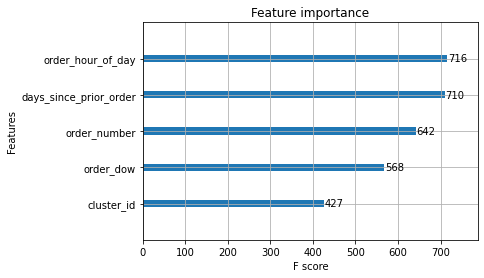

In [86]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [87]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [88]:
opjoin_test.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        25133                 11          4                  8   
        38928                 11          4                  8   
        26405                 11          4                  8   
        39657                 11          4                  8   

                    days_since_prior_order  cluster_id  
user_id product_id                                      
1       196                           14.0         1.0  
        25133                         14.0         1.0  
        38928                         14.0         1.0  
        26405                         14.0         1.0  
        39657                         14.0         1.0

In [89]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,1
3,26405,1,1
4,39657,1,1
...,...,...,...
201186,10644,49999,1
201187,26629,49999,1
201188,20980,49999,1
201189,7728,49999,1


In [90]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11,4,8,14.0,1
1,25133,1,1,11,4,8,14.0,1
2,38928,1,1,11,4,8,14.0,1
3,26405,1,1,11,4,8,14.0,1
4,39657,1,1,11,4,8,14.0,1


In [91]:
tally.head(40)

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11,4,8,14.0,1
1,25133,1,1,11,4,8,14.0,1
2,38928,1,1,11,4,8,14.0,1
3,26405,1,1,11,4,8,14.0,1
4,39657,1,1,11,4,8,14.0,1
5,10258,1,1,11,4,8,14.0,1
6,13032,1,1,11,4,8,14.0,1
7,26088,1,1,11,4,8,14.0,1
8,49235,1,1,11,4,8,14.0,1
9,46149,1,1,11,4,8,14.0,1


In [92]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y,compare
0,196,1,1,11,4,8,14.0,1,True
1,25133,1,1,11,4,8,14.0,1,True
2,38928,1,1,11,4,8,14.0,1,True
3,26405,1,1,11,4,8,14.0,1,True
4,39657,1,1,11,4,8,14.0,1,True


In [93]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201191 entries, 0 to 201190
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   product_id              201191 non-null  int64  
 1   user_id                 201191 non-null  int64  
 2   reordered_predicted     201191 non-null  int64  
 3   order_number            201191 non-null  int64  
 4   order_dow               201191 non-null  int8   
 5   order_hour_of_day       201191 non-null  int8   
 6   days_since_prior_order  201191 non-null  float16
 7   expected_y              201191 non-null  int64  
 8   compare                 201191 non-null  bool   
dtypes: bool(1), float16(1), int64(5), int8(2)
memory usage: 10.2 MB


In [94]:
true_count = tally['compare'].sum()
true_count

201191

In [95]:
false_count = len(tally['compare'])
false_count

201191

In [96]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 100.0 %


In [97]:
tally.head(40)

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y,compare
0,196,1,1,11,4,8,14.0,1,True
1,25133,1,1,11,4,8,14.0,1,True
2,38928,1,1,11,4,8,14.0,1,True
3,26405,1,1,11,4,8,14.0,1,True
4,39657,1,1,11,4,8,14.0,1,True
5,10258,1,1,11,4,8,14.0,1,True
6,13032,1,1,11,4,8,14.0,1,True
7,26088,1,1,11,4,8,14.0,1,True
8,49235,1,1,11,4,8,14.0,1,True
9,46149,1,1,11,4,8,14.0,1,True


[[201191]]


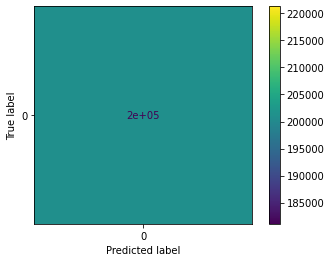

In [98]:
# from sklearn import metrics

# cm = metrics.confusion_matrix(tally['expected_y'], tally['reordered_predicted'])
# print(cm)

# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()